### We are going to analyze the region between 120mb and 150mb of 2nd chromosome, where [LCT](https://www.genecards.org/cgi-bin/carddisp.pl?gene=LCT) is located at the middle

* [Method 1: Infer  $\beta$-splitting by SFS ](#first-bullet)
* [Method 2: Infer  $\beta$-splitting by tree split sizes ](#second-bullet)

In [6]:
### Our package: BIM
import sys
sys.path.append('/home/enes/bim/')# you should have this package on the sys.path

from utils import InferEta, PConst, Neutrality_Tests, Colless, intersect_with_weights, logfr

In [7]:
from Bimbalance import bSFS, bTree

In [8]:
import tskit
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from scipy.ndimage import gaussian_filter1d

plt.style.use('ggplot')

In [9]:
ts = tskit.load('LCT_YRI_CEU_CHB.trees')

In [10]:
pop_meta = pd.DataFrame([json.loads(ts.population(i).metadata) for i in range(3)])
pop_meta

,description,name,super_population
0,"Han Chinese in Beijing, China",CHB,EAS
1,Utah Residents (CEPH) with Northern and Wester...,CEU,EUR
2,"Yoruba in Ibadan, Nigeria",YRI,AFR


In [11]:
LCT = {}
for i in range(3):
    pop = pop_meta['name'][i]
    cur_ts = ts.simplify(ts.samples(i))
    LCT[pop] = cur_ts # LCT[pop] defines the treesequences spesific to population <pop>
    
    print('number of trees for',pop ,': ', cur_ts.num_trees)

number of trees for CHB :  43601
number of trees for CEU :  40491
number of trees for YRI :  69631


## Method 1: Infer  $\beta$-splitting by SFS  <a class="anchor" id="first-bullet"></a>

### Infer effective population sizes
* Effective population size usually estimated by using whole genome, but for the sake of this exercise we are going to estimate effective population size for each population by looking at their site frequency spectrum for the given region on chromosome 2. This is quite neccessary for our SFS-based method, since both splitting signal and the branch lengths are estimated by SFS, to not picking up spurious signal for splitting we first need to model $\eta$ (which is effective population size by time).  
* We will use a piecewise constant effective population size model. 
* Our method is compatible with user given population history too. For the best result, you can just give a picewise function model that you estimated by using your favorite tool.

In [12]:
t = np.logspace(np.log10(1), np.log10(100000), 100)
t = np.concatenate((np.array([0]), t)) # breakpoints for the time (by generations)

a1 = 0. #sequential l1 penalty 
a2 = 1e1 #sequential l2 penalty

In [13]:
from utils import InferEta, PConst

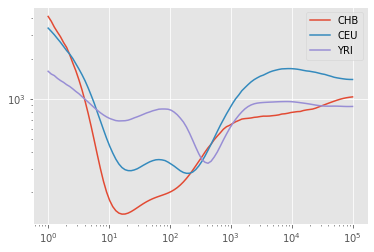

In [14]:
ePS = {} # Effective population sizes for each population for time t
for i in range(3):
    pop = pop_meta['name'][i]
    SFS = LCT[pop].allele_frequency_spectrum(span_normalise=False, polarised=True)[1:-1] # SFS for whole region
    N = len(SFS)+1 # sample size
    inferEta = InferEta(N, t, a1 = a1, a2 = a2)
    etaout = inferEta.predict(SFS, maxiter = 1000)
    
    ePS[pop] = etaout.x
    plt.plot(t[1:], ePS[pop][:-1], label = pop)
    
plt.yscale('log')
plt.xscale('log')
plt.legend()

### $\beta$-SFS for window sizes 100kbp

In [15]:
winsize = 100000
w = np.r_[0, np.arange(120_000_000, 150_000_000+1, winsize), 
          LCT[pop].get_sequence_length()]

# get the start and end points of 3000 sizes regions
start = w[1:-2]
end = w[2:-1]

In [16]:
df_betasfs = {}
for i in range(3):
    pop = pop_meta['name'][i]
    sfss = LCT[pop].allele_frequency_spectrum(span_normalise=False, 
                                              polarised=True,
                                              windows = w)[1:-1,1:-1] # SFS for each window
    
    N = sfss.shape[1] + 1
    eta = PConst(t = t, a = 1/ePS[pop])
    bsfs = bSFS(N, eta = eta, rho1 = 0., rho2 = 0.) # load the object for l2-penalized MLE
    
    nt = Neutrality_Tests(N)
    betasfs = []
    for i in trange(sfss.shape[0]):
        betasfs.append({'bsfs':bsfs.predict(sfss[i]).x[0], 'TajD':nt.TajD(sfss[i]), 'FayH':nt.FayH(sfss[i])})
        
    betasfs = pd.concat([pd.DataFrame({'start':start, 'end': end}), 
                         pd.DataFrame(betasfs)], axis = 1)

    df_betasfs[pop] = betasfs

#### Visualization 
We are going to create below contrast to get the population spesific signal
$$\beta_{CEU} \gets \beta_{CEU} - \beta_{YRI}$$
$$\beta_{CHB} \gets \beta_{CHB} - \beta_{YRI}$$

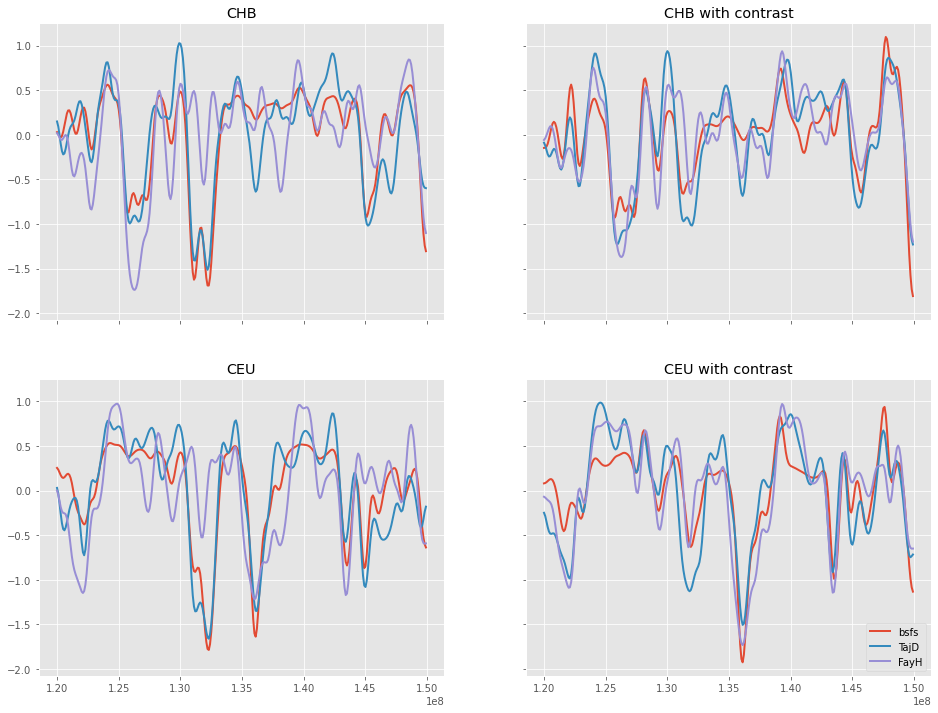

In [27]:
sm = 3

fig, ax = plt.subplots(2,2,figsize = (16,12), sharey = True, sharex = True)
for i, pop in enumerate(['CHB', 'CEU']):

    start = df_betasfs[pop].start.to_numpy()
    
    for key in ['bsfs', 'TajD', 'FayH']:
        yd = df_betasfs[pop][key].to_numpy() - df_betasfs['YRI'][key].to_numpy()       
        yd = (yd-yd.mean())/yd.std()
        ax[i,1].plot(start, gaussian_filter1d(yd, sm), label = key, linewidth = 2)
        
        y = df_betasfs[pop][key].to_numpy()
        y = (y-y.mean())/y.std()
        ax[i,0].plot(start, gaussian_filter1d(y, sm), label = key, linewidth = 2)
        
        
        ax[i, 1].set_title(pop+' with contrast')
        ax[i, 0].set_title(pop)

ax[1,1].legend(loc = 'lower right')
#ax[1,1].set_ylim(-1.2, 1.2)
fig.savefig('aroundLCT.pdf',  dpi=100) 

## Method 2: Infer  $\beta$-splitting by tree split sizes <a class="anchor" id="second-bullet"></a>

In [18]:
df_betatree = {}
for i in range(3):
    pop = pop_meta['name'][i]
    cur_ts = LCT[pop] 
    N = cur_ts.num_samples
    btree = bTree(N, rho1 = 0., rho2 = 0., log_pdf = logfr) 
    trees = cur_ts.trees()
    next(trees) # skip the first tree, the first one is empty
    
    betatree = []
    for i in trange(cur_ts.num_trees-2):
        Tree = next(trees)
        start, end = Tree.interval
        res = {'start':start, 'end':end}
        n, k = btree.tree_to_splits(Tree)['splits'] # tree -> splits
        res['btree'] = btree.predict(n, k, n-2).x[0] # splits -> betahat
        res['Colless'] = Colless(n, k)
        betatree.append(res)
        
    df_betatree[pop] = pd.DataFrame(betatree)

#### Visualization 

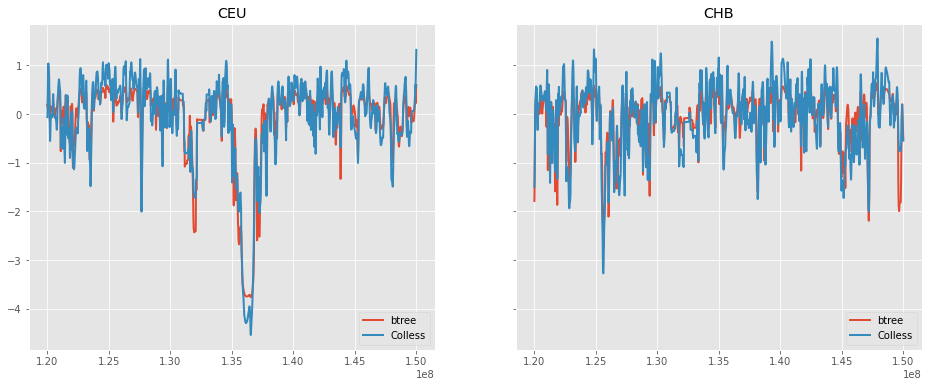

In [28]:
sm = 40
fig, ax = plt.subplots(1,2,figsize = (16,6), sharey = True)
for pop, i in zip(['CEU', 'CHB'], range(2)):

    start = df_betatree[pop].start.to_numpy()
    
    for key in ['btree', 'Colless']:
        y = df_betatree[pop][key].to_numpy()
        y = (y-y.mean())/y.std()
        
        if key == 'Colless':
            y = -y
        
        ax[i].plot(start, gaussian_filter1d(y, sm), label = key, linewidth = 2)
        
    ax[i].set_title(pop)
    ax[i].legend(loc = 'lower right')
    #ax[i].set_ylim(-1.2, 1.2)

#### Visualization with contrast

In [29]:
w = np.arange(120_000_000, 150_000_000+1, winsize)

In [30]:
w_betahats = {}
w_collesss = {}

for pop in pop_meta['name']:
    
    bs = df_betatree[pop]['start'].to_numpy()
    be = df_betatree[pop]['end'].to_numpy()
    cps = w[:-1]
    cpe = w[1:]

    y = df_betatree[pop][['btree', 'Colless']].to_numpy()
    dx = intersect_with_weights(bs, be, cps, cpe, y)
    dx = pd.DataFrame(dx)
    dx['btree'] = dx['val'].apply(lambda x: x[0])
    dx['Colless'] = dx['val'].apply(lambda x: x[1])
    dx = dx.drop(columns = 'val')
    dx = dx.groupby(['start', 'end'])[['btree', 'Colless']].mean().reset_index()
    
    w_betahats[pop] = dx['btree'].to_numpy()
    w_collesss[pop] = dx['Colless'].to_numpy()

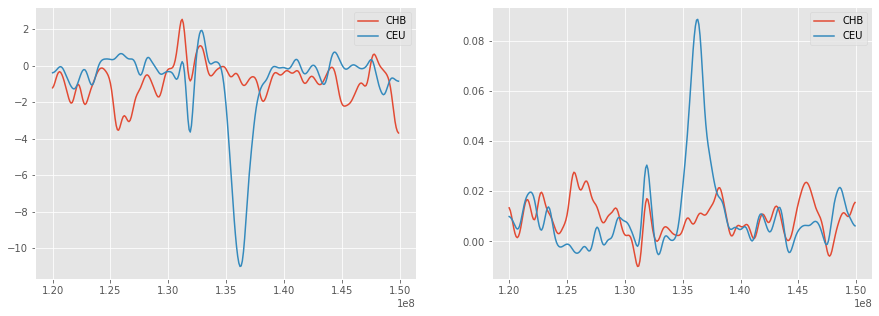

In [31]:
sm = 3
f= lambda y: gaussian_filter1d(y, sm)
fig, ax = plt.subplots(1,2,figsize = (15,5))
for pop in ['CHB', 'CEU']:
    ax[0].plot(w[:-1], f(w_betahats[pop]-w_betahats['YRI']), label = pop)
    ax[1].plot(w[:-1], f(w_collesss[pop]-w_collesss['YRI']), label = pop)
ax[0].legend()
ax[1].legend()

Lastly, correlation between b-SFS and b-tree:

In [32]:
import scipy
for pop in pop_meta['name']:
    print(pop,':')
    
    bhatsfs = df_betasfs[pop]['bsfs'].to_numpy()
    bhattree = w_betahats[pop]
    
    print(scipy.stats.pearsonr(bhattree, bhatsfs))

CHB :
(0.4278778522389106, 8.743869940053297e-15)
CEU :
(0.4726355918791423, 4.2243078585913054e-18)
YRI :
(0.5068783935755461, 5.486255979111957e-21)


Conclusion: Estimating the trees and then modeling the $\beta$-splitting gives more pronunced results for LCT